In [1]:
import json
import os
import numpy as np
import scipy.ndimage
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import random

# Define base directory for your data
base_dir = 'k:/HSI/'

# Load the JSON files
def load_data(file_path):
    with open(file_path) as f:
        return json.load(f)

data_train = load_data('k:/HSI/train_only_labeled_v2.json')

# Map ripeness states to numerical labels
ripeness_map = {
    "unripe": 0,
    "perfect": 1,
    "overripe": 2
}

# Function to read the binary data
def read_bin_file(bin_file_path, hdr_file_path):
    try:
        with open(hdr_file_path, 'r') as f:
            for line in f:
                if "samples" in line:
                    width = int(line.split('=')[-1].strip())
                elif "lines" in line:
                    height = int(line.split('=')[-1].strip())
                elif "bands" in line:
                    bands = int(line.split('=')[-1].strip())

        bin_path = os.path.join(base_dir, bin_file_path)
        with open(bin_path, 'rb') as f:
            data = np.fromfile(f, dtype=np.float32)
        data = data.reshape((height, width, bands))
        
        return data
    
    except FileNotFoundError as e:
        print(f"File not found: {e.filename}")
        return None

# Function to resize hyperspectral data to a consistent shape
def resize_hyperspectral_data(data, target_shape=(64, 64, 224)):
    current_shape = data.shape
    if current_shape != target_shape:
        zoom_factors = [target_shape[i] / current_shape[i] for i in range(3)]
        resized_data = scipy.ndimage.zoom(data, zoom_factors, order=1)
        return resized_data
    return data

# Function to extract features and labels
def extract_features_and_labels(data, annotations_dict, X_list, y_ripeness_list):
    for record in data['records']:
        if record['fruit'].lower() == "kaki":
            bin_file = record['files']['data_file']
            hdr_file = record['files']['header_file']
            record_id = record['id']
            
            # Load and resize hyperspectral data
            hyperspectral_data = read_bin_file(bin_file, hdr_file)
            if hyperspectral_data is None:
                continue
            
            hyperspectral_data = resize_hyperspectral_data(hyperspectral_data)
            X_list.append(hyperspectral_data)

            # Get ripeness annotation
            if record_id in annotations_dict:
                ripeness_state = annotations_dict[record_id]['ripeness_state']
                y_ripeness_list.append(ripeness_map[ripeness_state])
            else:
                print(f"Warning: No annotation found for record_id {record_id}")

# Prepare training data
annotations_dict_train = {annot['record_id']: annot for annot in data_train['annotations']}
X, y_ripeness = [], []
extract_features_and_labels(data_train, annotations_dict_train, X, y_ripeness)

# Convert to numpy arrays
X = np.array(X)
y_ripeness = np.array(y_ripeness)

# One-hot encode the ripeness labels
y_ripeness = to_categorical(y_ripeness, num_classes=3)

# Function to augment a single hyperspectral image by applying random transformations
def augment_image(data):
    if random.choice([True, False]):
        data = np.flip(data, axis=0)  # Flip vertically
    if random.choice([True, False]):
        data = np.flip(data, axis=1)  # Flip horizontally
    if random.choice([True, False]):
        data = scipy.ndimage.rotate(data, angle=random.randint(-20, 20), axes=(0, 1), reshape=False)
    if random.choice([True, False]):
        shift = random.uniform(-0.1, 0.1)
        data = scipy.ndimage.shift(data, shift=[shift, shift, 0], mode='nearest')
    
    return data

# Function to balance classes using augmentation
def balance_classes(X, y, target_count=84):
    X_balanced, y_balanced = [], []
    for class_label in range(3):  # For each class label
        class_indices = np.where(np.argmax(y, axis=1) == class_label)[0]
        current_count = len(class_indices)
        print("i am in")
        # Add original samples for the class
        for idx in class_indices:
            X_balanced.append(X[idx])
            y_balanced.append(y[idx])
        
        # Generate augmented samples if the current count is less than the target count
        if current_count < target_count:
            augment_needed = target_count - current_count
            for _ in range(augment_needed):
                original = X[random.choice(class_indices)]
                augmented = augment_image(original)
                X_balanced.append(augmented)
                y_balanced.append(to_categorical(class_label, num_classes=3))
    
    return np.array(X_balanced), np.array(y_balanced)

# Balance the classes
target_count = max(np.count_nonzero(y_ripeness == 1), 84)  # Setting target as the highest count among classes
X_balanced, y_balanced = balance_classes(X, y_ripeness, target_count=target_count)
print(y_balanced)
# Train-test split on the balanced dataset
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Print the shapes to verify
print("Shapes after balancing:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)

i am in
i am in
i am in
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
Shapes after balancing:
X_train: (268, 64, 64, 224)
y_train: (268, 3)
X_val: (68, 64, 64, 224)
y_val: (68, 3)


In [2]:
import tensorflow as tf
import numpy as np
import random

# Base neural network model
def build_model(input_shape, num_classes, num_layers=3, units=64, activation='relu'):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
    
    # Adding hidden layers based on genetic parameters
    for _ in range(num_layers):
        model.add(tf.keras.layers.Dense(units, activation=activation))
        model.add(tf.keras.layers.BatchNormalization())

    # Flatten or pool before the output layer to match the target shape
    model.add(tf.keras.layers.Flatten())  # Flatten to ensure the output is 1D
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Fitness function to evaluate a model
def evaluate_fitness(model, X_train, y_train, X_val, y_val, epochs=5):
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=0)
    val_accuracy = history.history['val_accuracy'][-1]
    return val_accuracy

# Genetic Algorithm parameters
population_size = 10
generations = 5
input_shape = X_train.shape[1:]  # Shape of the hyperspectral data
num_classes = y_train.shape[1]

# Initial population
population = [
    {
        "num_layers": random.randint(2, 5),
        "units": random.choice([32, 64, 128]),
        "activation": random.choice(['relu', 'tanh'])
    }
    for _ in range(population_size)
]

# Genetic Algorithm process
for generation in range(generations):
    print(f"Generation {generation + 1}")
    fitness_scores = []
    
    # Evaluate each individual in the population
    for individual in population:
        model = build_model(input_shape, num_classes, **individual)
        fitness = evaluate_fitness(model, X_train, y_train, X_val, y_val)
        fitness_scores.append((fitness, individual))
    
    # Select the best-performing individuals
    fitness_scores.sort(reverse=True, key=lambda x: x[0])
    population = [ind for _, ind in fitness_scores[:population_size // 2]]
    
    # Crossover and mutation
    while len(population) < population_size:
        parent1, parent2 = random.sample(population[:population_size // 2], 2)
        child = {
            "num_layers": random.choice([parent1["num_layers"], parent2["num_layers"]]),
            "units": random.choice([parent1["units"], parent2["units"]]),
            "activation": random.choice([parent1["activation"], parent2["activation"]])
        }
        # Mutation
        if random.random() < 0.1:
            child["num_layers"] = random.randint(2, 5)
        if random.random() < 0.1:
            child["units"] = random.choice([32, 64, 128])
        if random.random() < 0.1:
            child["activation"] = random.choice(['relu', 'tanh'])
        
        population.append(child)

# Best model after genetic optimization
best_model_config = fitness_scores[0][1]
best_model = build_model(input_shape, num_classes, **best_model_config)
best_model.fit(X_train, y_train, epochs=70, validation_data=(X_val, y_val))


Generation 1


C:\Users\kpoff\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Generation 2
Generation 3
Generation 4
Generation 5
Epoch 1/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 308ms/step - accuracy: 0.4852 - loss: 37.7344 - val_accuracy: 0.3824 - val_loss: 10.9837
Epoch 2/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - accuracy: 0.6019 - loss: 22.4527 - val_accuracy: 0.3824 - val_loss: 7.9279
Epoch 3/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 284ms/step - accuracy: 0.8053 - loss: 7.0214 - val_accuracy: 0.4412 - val_loss: 5.9230
Epoch 4/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 299ms/step - accuracy: 0.8686 - loss: 5.0266 - val_accuracy: 0.5294 - val_loss: 4.1384
Epoch 5/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 301ms/step - accuracy: 0.9262 - loss: 2.2776 - val_accuracy: 0.5441 - val_loss: 4.6485
Epoch 6/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 294ms/step - accuracy: 0.8983 - loss: 4.0208 - val_accuracy: 0.4265 - val_loss: 8.3461
Epoch 7/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 290ms/step - accuracy: 0.8866 - loss: 3.3839 - val_accuracy: 0.5000 - val_loss: 4.8549
Epoch 8/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 278ms/step - accuracy: 0

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Classification Report:
              precision    recall  f1-score   support

      Unripe       1.00      1.00      1.00        26
     Perfect       0.86      0.95      0.90        20
    Overripe       0.95      0.86      0.90        22

    accuracy                           0.94        68
   macro avg       0.94      0.94      0.94        68
weighted avg       0.94      0.94      0.94        68



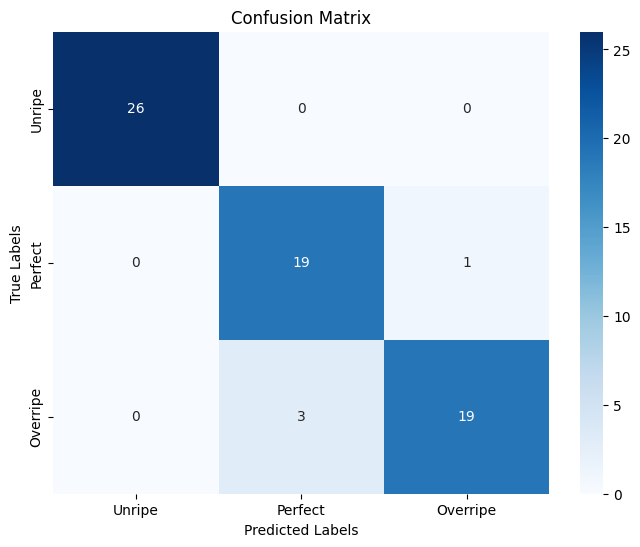

In [3]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions on the validation/test set
y_pred = best_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
y_true_classes = np.argmax(y_val, axis=1)  # True class labels

# Print classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=['Unripe', 'Perfect', 'Overripe']))

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Unripe', 'Perfect', 'Overripe'], yticklabels=['Unripe', 'Perfect', 'Overripe'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
